In [25]:
import os,zipfile

In [26]:
# os.mkdir('dataset')
dataset_dir = 'dataset'

In [27]:
target_file = 'indonesian-salary-by-region-19972022.zip'

In [28]:
extracting = zipfile.ZipFile(target_file, 'r')
extracting.extractall(dataset_dir)
extracting.close()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression

import os
for dirname, _, filenames in os.walk(f'{dataset_dir}/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/Indonesian Salary by Region (1997-2022).csv


In [30]:
ump_data = pd.read_csv(f"{dataset_dir}/Indonesian Salary by Region (1997-2022).csv")
ump_data.head()

,REGION,SALARY,YEAR
0,ACEH,128000,1997
1,SUMATERA UTARA,151000,1997
2,SUMATERA BARAT,119000,1997
3,RIAU,151500,1997
4,JAMBI,119500,1997


In [31]:
ump_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  870 non-null    object
 1   SALARY  870 non-null    int64 
 2   YEAR    870 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 20.5+ KB


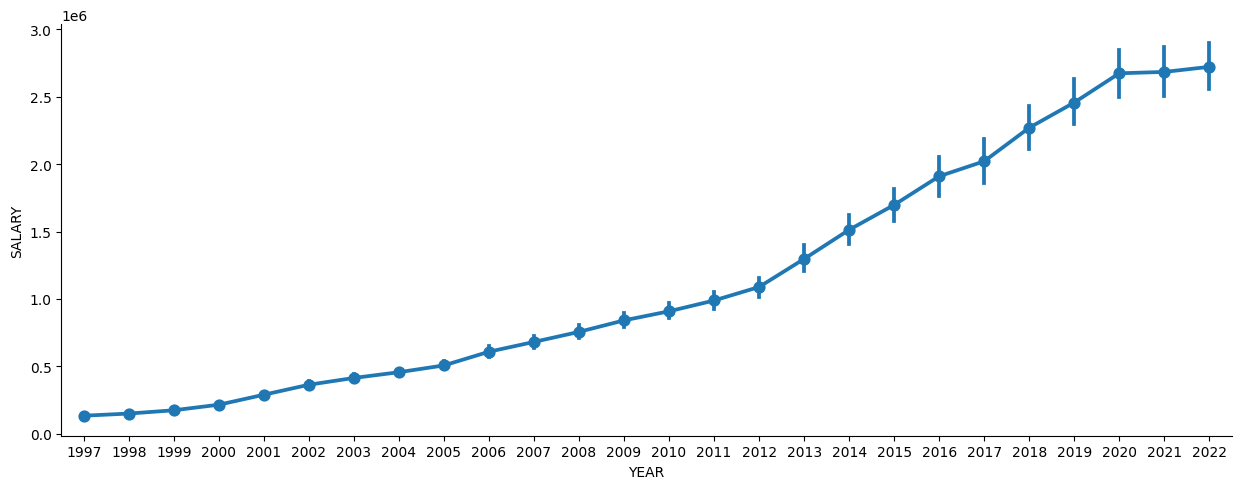

In [32]:
sns.catplot(x='YEAR', y='SALARY', data=ump_data, kind='point', aspect=2.5)

In [33]:
ump_data['SALARY'] = pd.to_numeric(ump_data['SALARY'], errors='coerce')

avg = ump_data.groupby(["YEAR"])['SALARY'].mean().reset_index()
avg.head()

,YEAR,SALARY
0,1997,134964.285714
1,1998,150937.500000
2,1999,175390.625000
3,2000,216506.250000
4,2001,290487.500000


In [34]:
growth=[0]
for i in range(1,26):
    growth.append(avg["SALARY"][i]-avg["SALARY"][i-1])

avg["growth"]=growth
avg.head()

,YEAR,SALARY,growth
0,1997,134964.285714,0.000000
1,1998,150937.500000,15973.214286
2,1999,175390.625000,24453.125000
3,2000,216506.250000,41115.625000
4,2001,290487.500000,73981.250000


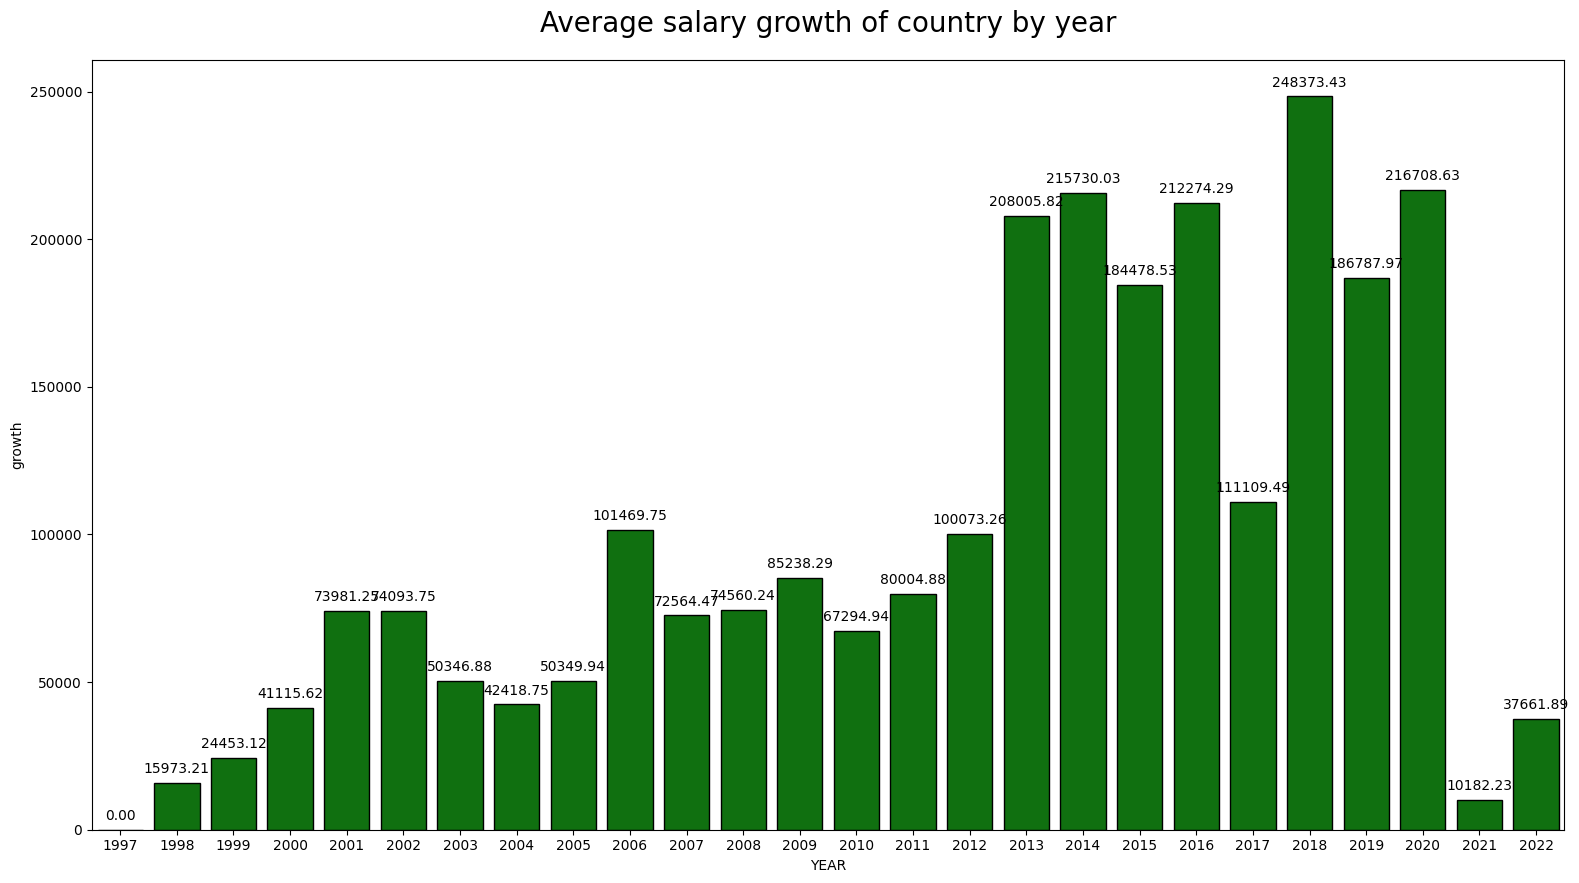

In [35]:
plt.figure(figsize=(19,10))
plt.title("Average salary growth of country by year", size=20, pad=20)

ax = sns.barplot(x='YEAR', y='growth', data=avg, color='green', edgecolor="black")

# loop through each bar and annotate
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

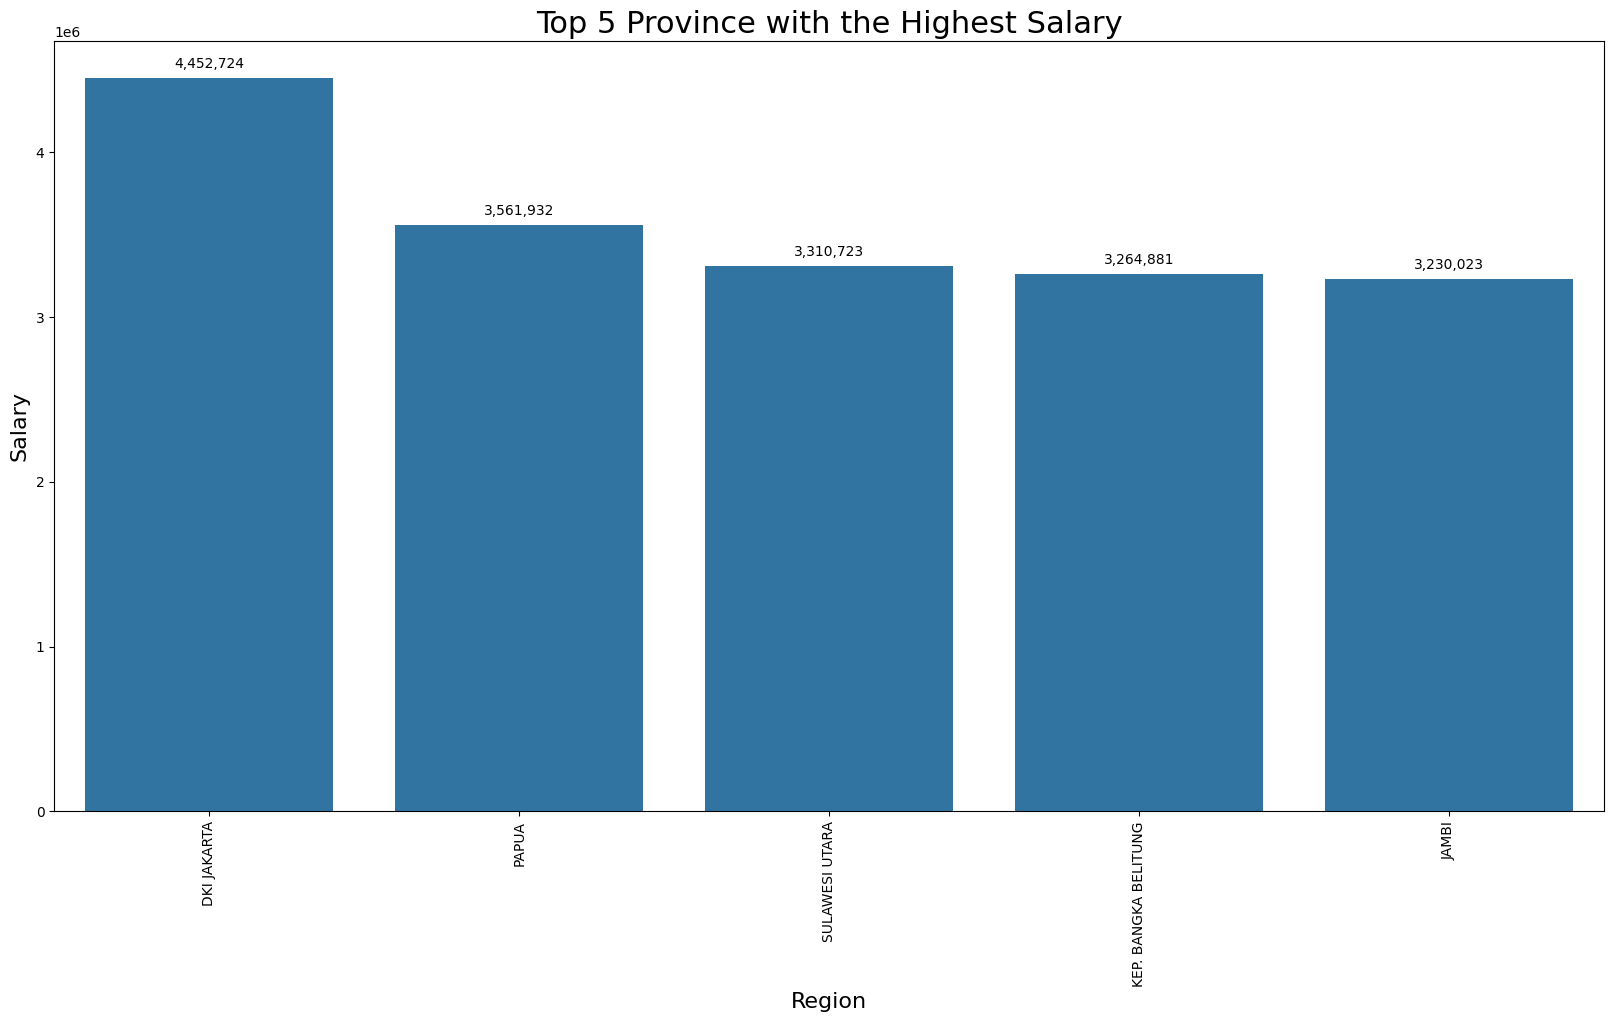

In [36]:
# ambil 5 region dengan salary tertinggi
top_5_regions = ump_data.groupby('REGION')['SALARY'].max().sort_values(ascending=False)[:5]
top_5_regions = top_5_regions.reset_index()

plt.figure(figsize = (20, 10))
graph = sns.barplot(x = 'REGION', y = 'SALARY', data=top_5_regions, order=top_5_regions['REGION'])
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
plt.xlabel('Region', fontsize=16)
plt.ylabel('Salary', fontsize=16)
plt.title('Top 5 Province with the Highest Salary', fontsize=22)

for index, row in top_5_regions.iterrows():
    graph.annotate(format(int(row['SALARY']), ','),
                   (row.name, row['SALARY']),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

In [37]:
ump_data = ump_data.reset_index(drop=True).groupby('REGION').apply(lambda x: x.sort_values('YEAR'))

models = {}
for provinsi in ump_data['REGION'].unique():
    X = ump_data.loc[ump_data['REGION'] == provinsi]['YEAR'].values.reshape(-1, 1)
    y = ump_data.loc[ump_data['REGION'] == provinsi]['SALARY'].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    models[provinsi] = model

In [38]:
future_years = np.array(range(ump_data['YEAR'].max() + 1, ump_data['YEAR'].max() + 11))
future_ump = []
for provinsi in ump_data['REGION'].unique():
    model = models[provinsi]
    future_ump_provinsi = model.predict(future_years.reshape(-1, 1))
    future_ump.extend(future_ump_provinsi)

In [39]:
future_df = pd.DataFrame({
    'REGION': np.repeat(ump_data['REGION'].unique(), 10),
    'YEAR': np.tile(range(ump_data['YEAR'].max() + 1, ump_data['YEAR'].max() + 11), ump_data['REGION'].nunique()),
    'SALARY': future_ump
})

In [40]:
future_df['SALARY'] = future_df['SALARY'].astype(int)
future_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  350 non-null    object
 1   YEAR    350 non-null    int64 
 2   SALARY  350 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB


In [41]:
future_df.head()

,REGION,YEAR,SALARY
0,ACEH,2023,3167366
1,ACEH,2024,3300026
2,ACEH,2025,3432686
3,ACEH,2026,3565346
4,ACEH,2027,3698006


In [42]:
combined_df = pd.concat([ump_data, future_df],axis=0,ignore_index=True)

In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  1220 non-null   object
 1   SALARY  1220 non-null   int64 
 2   YEAR    1220 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.7+ KB


In [44]:
combined_df.head()

,REGION,SALARY,YEAR
0,ACEH,128000,1997
1,ACEH,147000,1998
2,ACEH,171000,1999
3,ACEH,265000,2000
4,ACEH,300000,2001


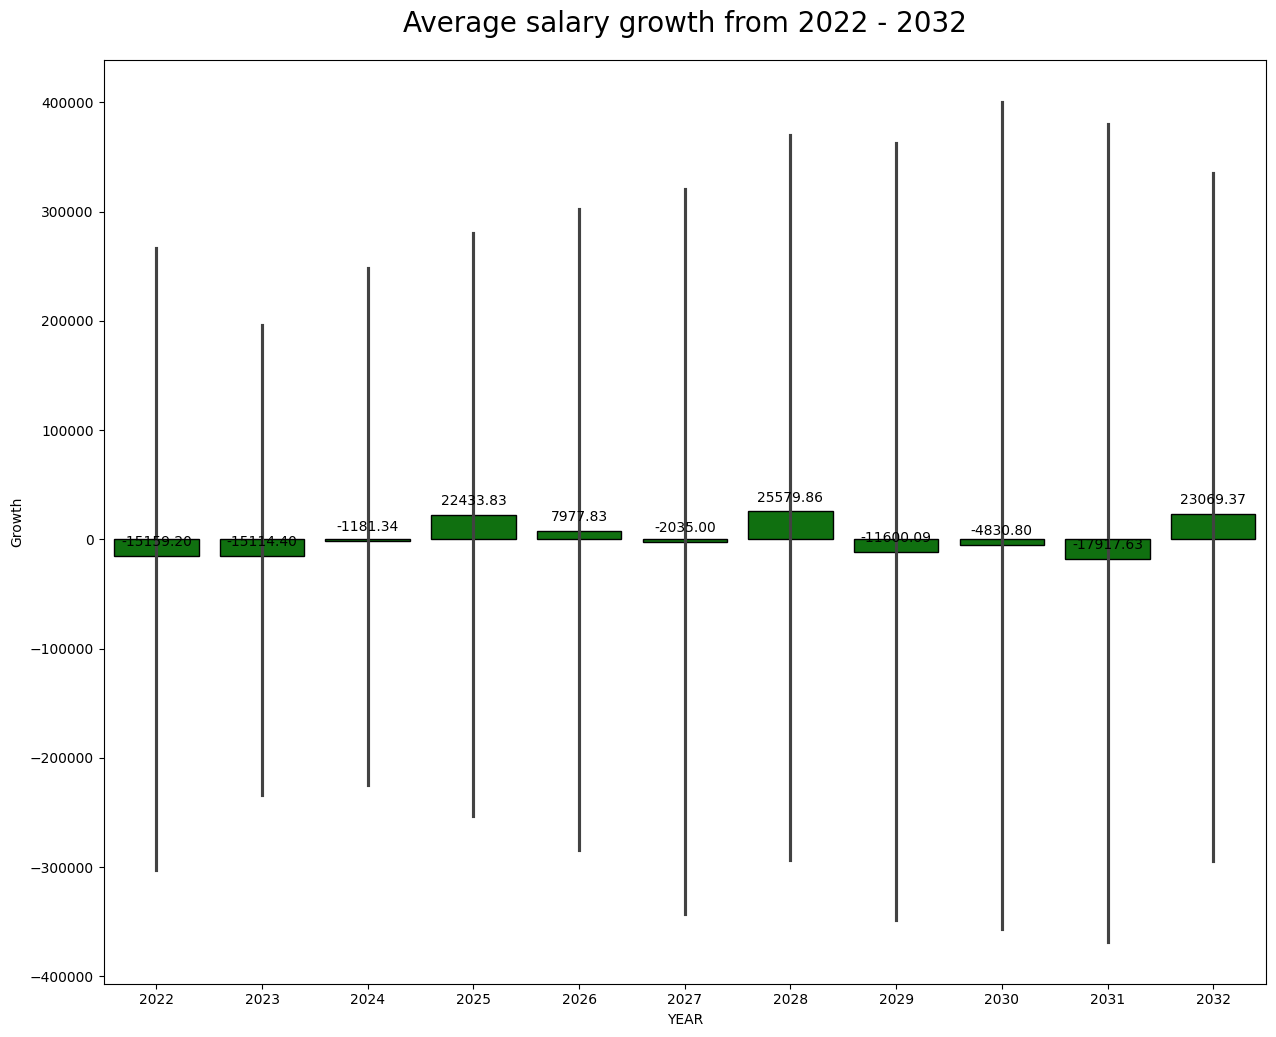

In [45]:
AVG = combined_df.sort_values(by='YEAR', ascending=True)

AVG['Growth'] = [0] + [AVG['SALARY'].iloc[i] - AVG['SALARY'].iloc[i-1] for i in range(1, len(AVG))]

plt.figure(figsize=(15,12))
plt.title("Average salary growth from 2022 - 2032", size=20, pad=20)

AVG_filtered = AVG.query('YEAR >= 2022 and YEAR <= 2032')

ax = sns.barplot(x='YEAR', y='Growth', data=AVG_filtered, color='green', edgecolor="black")

# loop through each bar and annotate
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

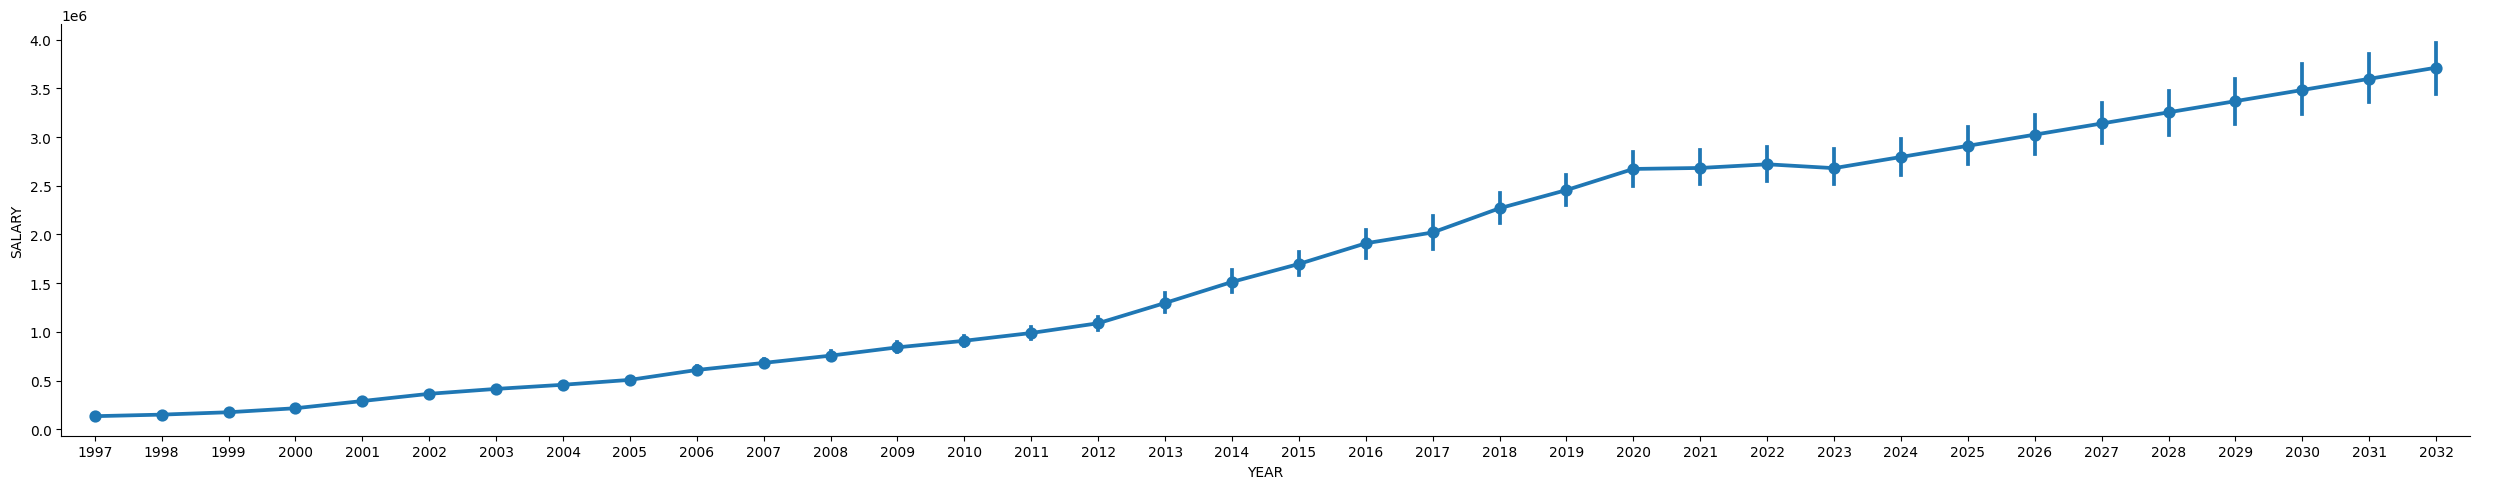

In [46]:
sns.catplot(x='YEAR', y='SALARY', data=combined_df, kind='point', aspect=5)

In [47]:
import plotly.express as px

fig = px.bar(combined_df, x='REGION', y="SALARY",color="REGION",
  animation_frame="YEAR", range_y=[0,7000000])
fig.show()

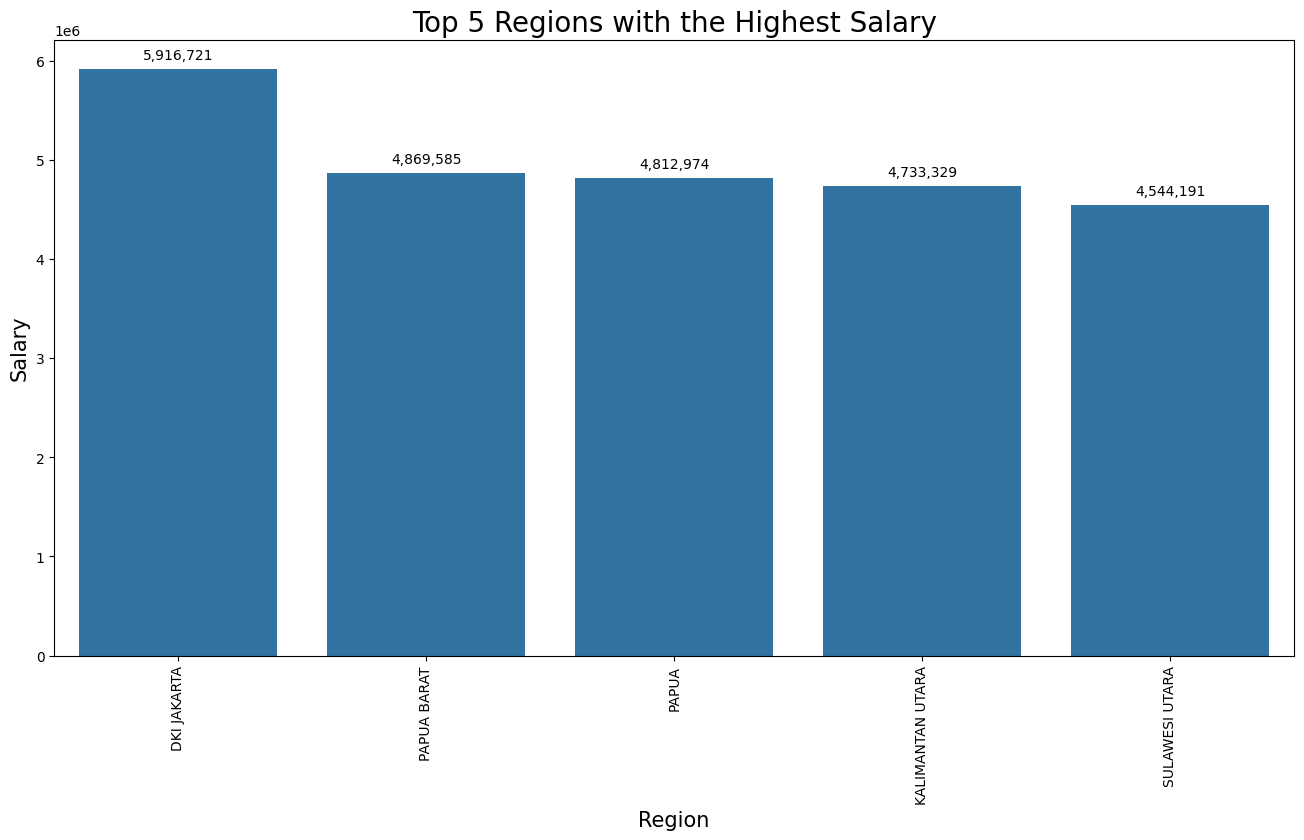

In [48]:
# ambil 5 region dengan salary tertinggi
top_5_regions = combined_df.groupby('REGION')['SALARY'].max().sort_values(ascending=False)[:5]
top_5_regions = top_5_regions.reset_index()



plt.figure(figsize = (16, 8))
graph = sns.barplot(x = 'REGION', y = 'SALARY', data=top_5_regions, order=top_5_regions['REGION'])
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Salary', fontsize=15)
plt.title('Top 5 Regions with the Highest Salary', fontsize=20)

for index, row in top_5_regions.iterrows():
    graph.annotate(format(int(row['SALARY']), ','),
                   (row.name, row['SALARY']),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluasi model untuk setiap region
for provinsi in ump_data['REGION'].unique():
    X = ump_data.loc[ump_data['REGION'] == provinsi]['YEAR'].values.reshape(-1, 1)
    y = ump_data.loc[ump_data['REGION'] == provinsi]['SALARY'].values.reshape(-1, 1)
    model = models[provinsi]
    predictions = model.predict(X)
    
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"Evaluasi untuk {provinsi}:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.2f}")


Evaluasi untuk ACEH:
MAE: 191413.50
MSE: 45576092711.57
R²: 0.96
Evaluasi untuk BALI:
MAE: 185859.04
MSE: 46308203808.38
R²: 0.93
Evaluasi untuk BANTEN:
MAE: 138543.71
MSE: 27608261669.80
R²: 0.95
Evaluasi untuk BENGKULU:
MAE: 163985.63
MSE: 50873517781.38
R²: 0.91
Evaluasi untuk DI YOGYAKARTA:
MAE: 102959.67
MSE: 13971425087.34
R²: 0.95
Evaluasi untuk DKI JAKARTA:
MAE: 375131.34
MSE: 186864159042.43
R²: 0.91
Evaluasi untuk GORONTALO:
MAE: 254128.69
MSE: 84455981713.77
R²: 0.89
Evaluasi untuk INDONESIA:
MAE: 181085.73
MSE: 44050110008.31
R²: 0.94
Evaluasi untuk JAMBI:
MAE: 197485.73
MSE: 63134757823.13
R²: 0.92
Evaluasi untuk JAWA BARAT:
MAE: 168687.85
MSE: 57021513237.82
R²: 0.85
Evaluasi untuk JAWA TENGAH:
MAE: 142238.53
MSE: 25390555628.64
R²: 0.91
Evaluasi untuk JAWA TIMUR:
MAE: 151470.56
MSE: 27479981777.42
R²: 0.91
Evaluasi untuk KALIMANTAN BARAT:
MAE: 196027.51
MSE: 49548402938.52
R²: 0.92
Evaluasi untuk KALIMANTAN SELATAN:
MAE: 194673.05
MSE: 48643742963.19
R²: 0.94
Evaluasi un